<a href="https://colab.research.google.com/github/ochekroun/labs/blob/master/IFAGE_Cours_4_D%C3%A9tection_d'objets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detection d'objets avec YOLO v8

In [1]:
!pip install -q --upgrade keras-cv keras --use-deprecated=legacy-resolver

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 56.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 22.1 MB/s eta 0:00:00
ERROR: pip's legacy dependency resolver does not consider dependency conflicts when selecting packages. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you'll have keras 3.3.3 which is incompatible.


In [2]:
from tensorflow import data as tf_data
import tensorflow_datasets as tfds
import keras
import keras_cv
import numpy as np
from keras_cv import bounding_box
import os
from keras_cv import visualization
import tqdm

Utilisons le modèle pré-entraîné `yolo_v8_m_pascalvoc` :

In [3]:
pretrained_model = keras_cv.models.YOLOV8Detector.from_preset(
    "yolo_v8_m_pascalvoc", bounding_box_format="xywh"
)

100%|██████████| 2.27k/2.27k [00:00<00:00, 3.05MB/s]
100%|██████████| 99.5M/99.5M [00:00<00:00, 173MB/s]


In [4]:
filepath = keras.utils.get_file(origin="https://storage.googleapis.com/misc-17608/gCNcJJI.jpeg")
image = keras.utils.load_img(filepath)
image = np.array(image)

1215963/1215963 ━━━━━━━━━━━━━━━━━━━━ 1s 1us/step


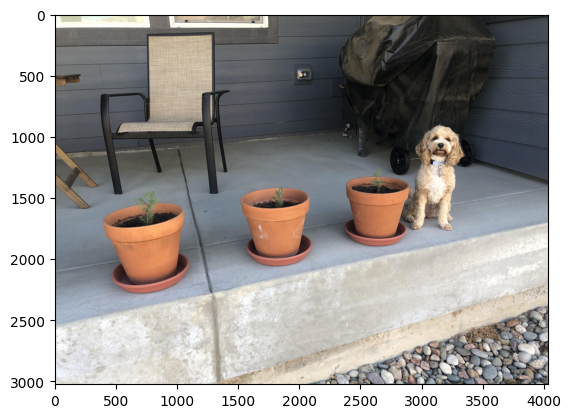

In [5]:
import matplotlib.pyplot as plt
plt.imshow(image)

L'image doit être redimensionnée dans une dimensions divisable par 64.

In [6]:
inference_resizing = keras_cv.layers.Resizing(
    640, 640,
    pad_to_aspect_ratio=True,
    bounding_box_format="xywh"
)

In [7]:
image_batch = inference_resizing([image])

La prédiction s'effectue comme avec n'importe quel modèle Keras :

In [8]:
y_pred = pretrained_model.predict(image_batch)

1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step


Cependant, dur de comprendre à quoi ressemblent ces boîtes !

In [9]:
y_pred

{'boxes': array([[[449.5106  , 142.71707 ,  90.91403 , 141.12839 ],
         [374.74982 , 206.06046 ,  86.41052 ,  94.26886 ],
         [ 59.679276, 229.16298 , 114.074295, 130.60637 ],
         [238.03307 , 223.13684 ,  95.846085, 102.32648 ],
         [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
         [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
         [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
         [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
         [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
         [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
         [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
         [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
         [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
         [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
         [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
         [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
         [ -1.      ,  -1.      ,  -1.      ,  

On utilise l'utilitaire Keras `keras_cv.visualization.plot_bounding_box_gallery()` pour afficher le nom correct des classes sur les images :

In [10]:
class_ids = [
    "Aeroplane",
    "Bicycle",
    "Bird",
    "Boat",
    "Bottle",
    "Bus",
    "Car",
    "Cat",
    "Chair",
    "Cow",
    "Dining Table",
    "Dog",
    "Horse",
    "Motorbike",
    "Person",
    "Potted Plant",
    "Sheep",
    "Sofa",
    "Train",
    "Tvmonitor",
    "Total",
]
class_mapping = dict(zip(range(len(class_ids)), class_ids))

Affichons maintenant le résultat :

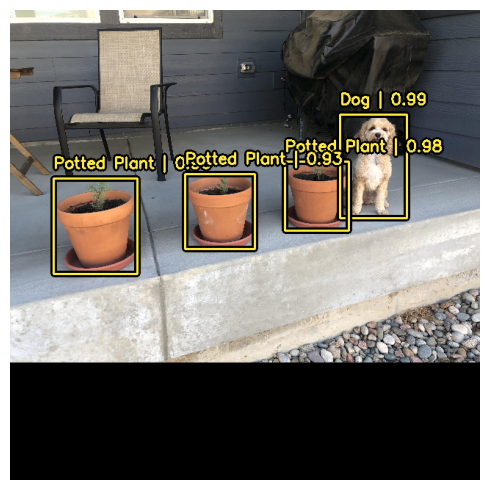

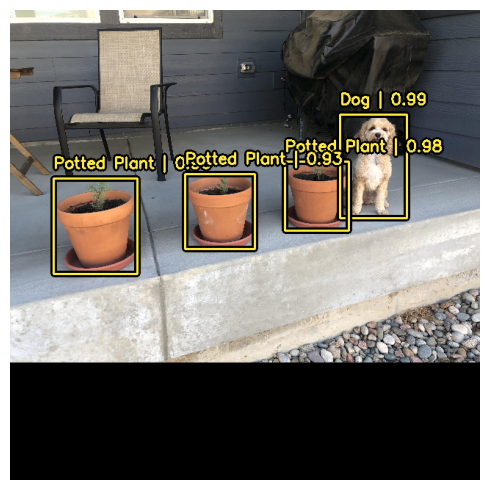

In [11]:
visualization.plot_bounding_box_gallery(
    image_batch,
    value_range=(0, 255),
    rows=1,
    cols=1,
    y_pred=y_pred,
    scale=5,
    font_scale=0.7,
    bounding_box_format="xywh",
    class_mapping=class_mapping,
)

YOLO commence par détecter bien plus de boîtes que nécessaire, puis les filtres avec un système de déduplication. Regardons le résultat sans cette dernière étape...

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


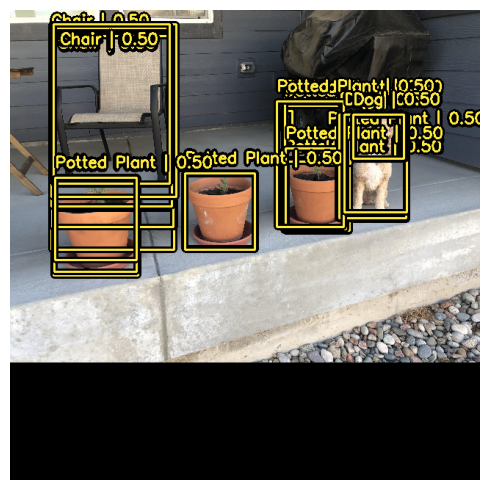

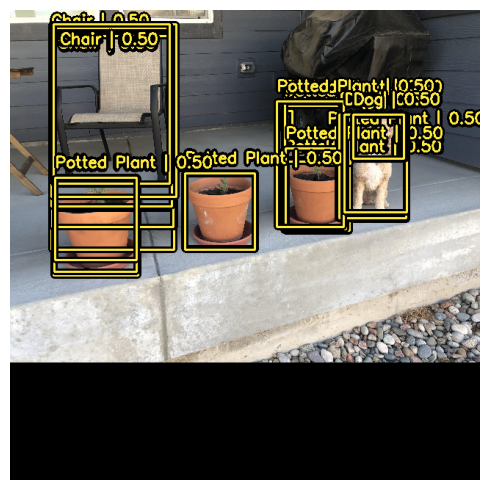

In [12]:
prediction_decoder = keras_cv.layers.NonMaxSuppression(
    bounding_box_format="xywh",
    from_logits=True,
    iou_threshold=1.0,
    confidence_threshold=0.0,
)
pretrained_model = keras_cv.models.YOLOV8Detector.from_preset(
    "yolo_v8_m_pascalvoc",
    bounding_box_format="xywh",
    prediction_decoder=prediction_decoder,
)

y_pred = pretrained_model.predict(image_batch)
visualization.plot_bounding_box_gallery(
    image_batch,
    value_range=(0, 255),
    rows=1,
    cols=1,
    y_pred=y_pred,
    scale=5,
    font_scale=0.7,
    bounding_box_format="xywh",
    class_mapping=class_mapping,
)
